<a href="https://colab.research.google.com/github/tikik/First-Git/blob/master/Copy_of_Homework1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
# # Patient-Level Train/Validation Split on CheXpert Dataset

## Objectives

Perform a **patient-level 80/20 train/validation split** on the CheXpert dataset from Hugging Face.

- Ensure **no data leakage**: images from the same patient only appear in one split.
- Use only **frontal view** images.

---

## Data Source

- Dataset: [danjacobellis/chexpert](https://huggingface.co/datasets/danjacobellis/chexpert) from Hugging Face.
- Format: Parquet (`.parquet`).
- Environment: Google Colab (due to memory/time constraints).
- Streaming mode is used to avoid memory and rate limit issues.
---

## Preprocessing Steps

### 0. Optional: Load Dataset with Retry Logic

### 1. Load with dask from Huggingface


In [19]:
# 0. This step is optional.
from datasets import load_dataset
import time

for attempt in range(5):
    try:
        dataset = load_dataset("danjacobellis/chexpert", split="train")
        break  # Success
    except Exception as e:
        print(f"Attempt {attempt + 1} failed: {e}")
        time.sleep(2 ** attempt)




README.md: 0.00B [00:00, ?B/s]

Resolving data files:   0%|          | 0/23 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/23 [00:00<?, ?it/s]

data/train-00000-of-00023.parquet:   0%|          | 0.00/487M [00:00<?, ?B/s]

data/train-00001-of-00023.parquet:   0%|          | 0.00/486M [00:00<?, ?B/s]

KeyboardInterrupt: 

In [35]:
# step 1: Using dask from Huggingface
import numpy as np
import pandas as pd
import dask.dataframe as dd

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from datasets import load_dataset

splits = {'train': 'data/train-*.parquet', 'validation': 'data/validation-00000-of-00001.parquet'}
df = dd.read_parquet("hf://datasets/danjacobellis/chexpert/" + splits["train"])

## Step 2: Convert Data to dataframe using pandas

In [21]:
df = pd.DataFrame.from_records(df.head(50000))

/usr/local/lib/python3.12/dist-packages/dask/dataframe/core.py:382: UserWarning: Insufficient elements for `head`. 50000 elements requested, only 9714 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(
/tmp/ipython-input-2302168727.py:1: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(df.head(50000))


In [ ]:
# Extract patient ID from 'Path' column, handling potential errors
df['PatientID'] = df['Path'].str.split('/').str[2]

In [26]:
# Take a look to see where are the columns for Fronal / Lateral View:
df.head()
# Filter for frontal views (assuming 'Frontal/Lateral' column contains 1 for frontal)
df = df[df['Frontal/Lateral'] == 1]


In [ ]:
# Preventing leakage by ensuring unique patients ID in both training and validating sets. Splitting this df into two parts:
unique_patients = df['PatientID'].unique()
train_patients, val_patients = train_test_split(unique_patients, test_size=0.2, random_state=42)

In [31]:
# 2. Peek at one row
print(df.iloc[0])

Path                          CheXpert-v1.0-small/train/patient00002/study1/...
Sex                                                                           1
Age                                                                          83
Frontal/Lateral                                                               1
AP/PA                                                                         2
No Finding                                                                    0
Enlarged Cardiomediastinum                                                    0
Cardiomegaly                                                                  0
Lung Opacity                                                                  3
Lung Lesion                                                                   0
Edema                                                                         0
Consolidation                                                                 1
Pneumonia                               

## Adding new column, values of this columns could be either train/val

In [ ]:
df['split'] = df['PatientID'].apply(lambda x: 'train' if x in train_patients else 'val')

In [ ]:
train_df = df[df['split'] == 'train']
val_df = df[df['split'] == 'val']

In [ ]:
print(len(train_df), len(val_df))


1601 386


Thus Train dataset has 1601 samples, validation set has 386 samples.

In [34]:
# DOWNLOADING THE FILES FROM OUR SPLITTED DATASETS, FOR LATER USAGE.
train_df.to_parquet("chexpert_train_frontal.parquet")
val_df.to_parquet("chexpert_val_frontal.parquet")
import os
print(os.getcwd())
print(os.listdir())

/content
['.config', 'chexpert_train_frontal.parquet', 'chexpert_val_frontal.parquet', 'sample_data']


## Preparing for plots


In [36]:
# Global mappings
LABEL_MAP = {0:"unlabeled", 1:"uncertain", 2:"negative", 3:"positive"}
VIEW_MAP  = {0:"AP", 1:"PA", 2:"no label"}
PLANE_MAP = {0:"Frontal", 1:"Lateral", 2:"no label"}
SEX_MAP   = {0:"Male", 1:"Female"}

AGE_BINS   = [0, 30, 45, 60, 75, 120]
AGE_LABELS = ["≤30", "31–45", "46–60", "61–75", "≥76"]

In [39]:
def load_and_prepare(split, target, second):
    """Load CheXpert split and preprocess labels, view, sex, age."""
    cols = [
        "Sex","Age","Frontal/Lateral","AP/PA","No Finding",
        target, second
    ]
    ds = load_dataset("danjacobellis/chexpert", split=split)
    df = ds.to_pandas()[cols]

    # Map labels
    for col in [target, second, "No Finding"]:
        df[col] = df[col].map(LABEL_MAP).astype("category")

    # Map views, plane, sex, age bins
    df["View"]  = df["AP/PA"].map(VIEW_MAP).fillna("unknown")
    df["Plane"] = df["Frontal/Lateral"].map(PLANE_MAP).fillna("unknown")
    df["Sex"]   = df["Sex"].map(SEX_MAP).astype("category")
    df["AgeBin"]= pd.cut(df["Age"], bins=AGE_BINS, labels=AGE_LABELS)

    return df

# Analysis Model:
def label_prevalence(df, target, plot=True):
    counts = df[target].value_counts().reindex(["positive","negative","uncertain","unlabeled"]).fillna(0)
    if plot:
        counts.plot(kind="bar", rot=0, title=f"{target} prevalence")
        plt.show()
    return counts

def co_occurrence(df, target, other):
    def binarize(s): return (s=="positive").map({True:"positive",False:"not positive"})
    co = pd.crosstab(binarize(df[target]), binarize(df[other]))
    return co

In [40]:
def distributions(df, target):
    results = {}

    # Restrict to frontal for AP/PA
    front = df[df["Plane"]=="Frontal"]

    results["view"] = pd.crosstab(front["View"], front[target])
    results["sex"]  = pd.crosstab(df["Sex"], df[target])
    results["age"]  = pd.crosstab(df["AgeBin"], df[target])

    return results

In [41]:
def class_priors(df, target):
    counts = df[target].value_counts().reindex(["positive","negative","uncertain","unlabeled"]).fillna(0)
    priors = counts / counts.sum()
    majority = priors.idxmax()
    error = 1 - priors.max()

    # Binary variants
    tmp0 = df[df[target]!="unlabeled"][target].replace({"uncertain":"negative"})
    p_pos0 = (tmp0=="positive").mean()
    error0 = 1 - max(p_pos0,1-p_pos0)

    tmp1 = df[df[target]!="unlabeled"][target].replace({"uncertain":"positive"})
    p_pos1 = (tmp1=="positive").mean()
    error1 = 1 - max(p_pos1,1-p_pos1)

    return {
        "4class_priors": priors,
        "majority_class": majority,
        "majority_error": error,
        "U0_p_pos": p_pos0, "U0_error": error0,
        "U1_p_pos": p_pos1, "U1_error": error1
    }

In [42]:
def run_analysis(split, target="Pleural Effusion", second="Cardiomegaly"):
    print(f"\n===== Analyzing {split} split =====")

    df = load_and_prepare(split, target, second)

    # (a) Prevalence
    prev = label_prevalence(df, target)
    print("(a) Prevalence:\n", prev)

    # (b) Co-occurrence
    co_no = co_occurrence(df, target, "No Finding")
    co_2  = co_occurrence(df, target, second)
    print("\n(b) Co-occurrence with No Finding:\n", co_no)
    print(f"\n(b) Co-occurrence with {second}:\n", co_2)

    # (c) Distributions
    dist = distributions(df, target)
    print("\n(c) Distribution by view:\n", dist["view"])
    print("\n(c) Distribution by sex:\n", dist["sex"])
    print("\n(c) Distribution by age:\n", dist["age"])

    # (d) Priors & baselines
    priors = class_priors(df, target)
    print("\n(d) Priors & baselines:\n", priors)



===== Analyzing validation split =====


Resolving data files:   0%|          | 0/23 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/23 [00:00<?, ?it/s]

data/train-00000-of-00023.parquet:   0%|          | 0.00/487M [00:00<?, ?B/s]

data/train-00001-of-00023.parquet:   0%|          | 0.00/486M [00:00<?, ?B/s]

data/train-00002-of-00023.parquet:   0%|          | 0.00/485M [00:00<?, ?B/s]

data/train-00003-of-00023.parquet:   0%|          | 0.00/485M [00:00<?, ?B/s]

data/train-00004-of-00023.parquet:   0%|          | 0.00/487M [00:00<?, ?B/s]

data/train-00005-of-00023.parquet:   0%|          | 0.00/484M [00:00<?, ?B/s]

data/train-00006-of-00023.parquet:   0%|          | 0.00/487M [00:00<?, ?B/s]

data/train-00007-of-00023.parquet:   0%|          | 0.00/485M [00:00<?, ?B/s]

data/train-00008-of-00023.parquet:   0%|          | 0.00/485M [00:00<?, ?B/s]

data/train-00009-of-00023.parquet:   0%|          | 0.00/484M [00:00<?, ?B/s]

data/train-00010-of-00023.parquet:   0%|          | 0.00/485M [00:00<?, ?B/s]

data/train-00011-of-00023.parquet:   0%|          | 0.00/486M [00:00<?, ?B/s]

data/train-00012-of-00023.parquet:   0%|          | 0.00/486M [00:00<?, ?B/s]

data/train-00013-of-00023.parquet:   0%|          | 0.00/485M [00:00<?, ?B/s]

data/train-00014-of-00023.parquet:   0%|          | 0.00/493M [00:00<?, ?B/s]

data/train-00015-of-00023.parquet:   0%|          | 0.00/523M [00:00<?, ?B/s]

data/train-00016-of-00023.parquet:   0%|          | 0.00/522M [00:00<?, ?B/s]

data/train-00017-of-00023.parquet:   0%|          | 0.00/524M [00:00<?, ?B/s]

data/train-00018-of-00023.parquet:   0%|          | 0.00/521M [00:00<?, ?B/s]

data/train-00019-of-00023.parquet:   0%|          | 0.00/520M [00:00<?, ?B/s]

data/train-00020-of-00023.parquet:   0%|          | 0.00/519M [00:00<?, ?B/s]

data/train-00021-of-00023.parquet:   0%|          | 0.00/519M [00:00<?, ?B/s]

data/train-00022-of-00023.parquet:   0%|          | 0.00/516M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/12.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/223414 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/234 [00:00<?, ? examples/s]

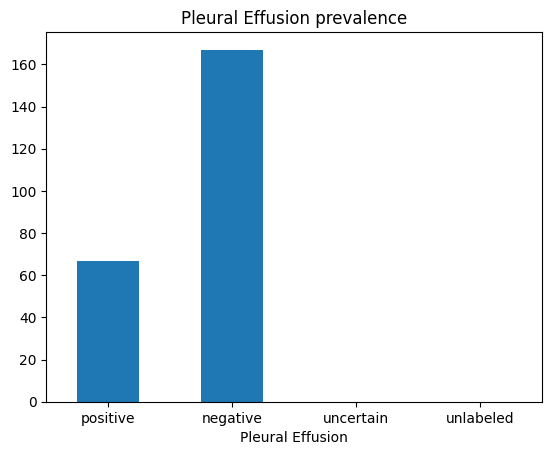

(a) Prevalence:
 Pleural Effusion
positive      67.0
negative     167.0
uncertain      0.0
unlabeled      0.0
Name: count, dtype: float64

(b) Co-occurrence with No Finding:
 No Finding        not positive  positive
Pleural Effusion                        
not positive               129        38
positive                    67         0

(b) Co-occurrence with Cardiomegaly:
 Cardiomegaly      not positive  positive
Pleural Effusion                        
not positive               129        38
positive                    37        30

(c) Distribution by view:
 Pleural Effusion  negative  positive
View                                
AP                     108        61
PA                      30         3

(c) Distribution by sex:
 Pleural Effusion  negative  positive
Sex                                 
Female                  65        41
Male                   102        26

(c) Distribution by age:
 Pleural Effusion  negative  positive
AgeBin                              
≤30   

Resolving data files:   0%|          | 0/23 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/23 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/23 [00:00<?, ?it/s]

In [ ]:
for split in ["validation","train"]:
    run_analysis(split, target="Pleural Effusion", second="Cardiomegaly")
